## 1. Install required libraries

In [18]:
!pip install gradio pandas numpy matplotlib pillow scikit-learn joblib langchain langgraph

## 2. Synthetic Data Generation - Core method
> generate_batch_data()

In [19]:
import pandas as pd
import numpy as np

def generate_batch_data(batch_length=48, seed=None):
    np.random.seed(seed) # Ensures variability between runs
    time_points = np.arange(batch_length + 1)

    # Simulated bioprocess values with realistic time trends
    pH = 7 + 0.02 * np.sin(0.2 * time_points) + np.random.normal(0, 0.05, batch_length + 1)
    temperature = 37 + np.random.normal(0, 0.5, batch_length + 1)
    viability = 95 + 5 * np.exp(-0.1 * (time_points - 30).clip(min=0)) + np.random.normal(0, 1, batch_length + 1)
    viability = np.clip(viability, 70, 100)
    max_vcd = 30
    vcd = max_vcd / (1 + np.exp(-0.3 * (time_points - 24))) + np.random.normal(0, 1, batch_length + 1)
    vcd = np.clip(vcd, 0, None)
    do = 80 - 0.5 * time_points + np.random.normal(0, 2, batch_length + 1)
    do = np.clip(do, 10, 100)
    co2 = 0.05 + 0.02 * time_points + np.random.normal(0, 0.005, batch_length + 1)
    co2 = np.clip(co2, 0, None)
    max_titer = 5
    titer = max_titer / (1 + np.exp(-0.3 * (time_points - 30))) + np.random.normal(0, 0.1, batch_length + 1)
    titer = np.clip(titer, 0, None)
    growth_rate = 0.5 * np.exp(-0.1 * time_points) + 0.05 * np.random.normal(0, 1, batch_length + 1)
    growth_rate = np.clip(growth_rate, 0, None)
    glucose = 5 * np.exp(-0.05 * time_points) + np.random.normal(0, 0.1, batch_length + 1)
    glucose = np.clip(glucose, 0, None)
    lactate = 2 / (1 + np.exp(-0.3 * (time_points - 20))) + np.random.normal(0, 0.1, batch_length + 1)
    lactate = np.clip(lactate, 0, None)
    ammonia = 0.5 * np.log1p(time_points) + np.random.normal(0, 0.05, batch_length + 1)
    ammonia = np.clip(ammonia, 0, None)
    calcium = 1.8 + np.random.normal(0, 0.05, batch_length + 1)
    calcium = np.clip(calcium, 0, None)
    na_k_ratio = 2 + 0.5 * np.sin(0.1 * time_points) + np.random.normal(0, 0.1, batch_length + 1)
    na_k_ratio = np.clip(na_k_ratio, 1, 4)
    agitation = 200 + np.random.normal(0, 5, batch_length + 1)
    cell_bleed = np.where(time_points > 36, 0.5 * (time_points - 36) + np.random.normal(0, 0.1, batch_length + 1), 0)
    cell_bleed = np.clip(cell_bleed, 0, None)
    culture_time = time_points

    batch_data = pd.DataFrame({
        'culture_time_hr': culture_time,
        'pH': pH,
        'temperature_C': temperature,
        'viability_pct': viability,
        'viable_cell_density_million_per_mL': vcd,
        'dissolved_oxygen_pct': do,
        'carbon_dioxide_pct': co2,
        'titer_g_per_L': titer,
        'growth_rate_per_hr': growth_rate,
        'glucose_g_per_L': glucose,
        'lactate_g_per_L': lactate,
        'ammonia_mM': ammonia,
        'calcium_mM': calcium,
        'sodium_potassium_ratio': na_k_ratio,
        'agitation_rpm': agitation,
        'cell_bleed_volume_mL': cell_bleed
    })
    return batch_data

### Optional - Visual dashboard to generate batch data

In [33]:
import matplotlib.pyplot as plt
import gradio as gr
import io
from PIL import Image
import traceback

def run_batch_simulation(batch_length=48):
    try:
        df = generate_batch_data(batch_length)
        csv_path = 'batch_data.csv'
        df.to_csv(csv_path, index=False)

        fig, axs = plt.subplots(3, 1, figsize=(8, 10))
        axs[0].plot(df['culture_time_hr'], df['viability_pct'], label='Viability %')
        axs[0].plot(df['culture_time_hr'], df['viable_cell_density_million_per_mL'], label='Viable Cell Density (M/mL)')
        axs[0].legend()
        axs[0].set_title('Cell Viability & Density Over Time')

        axs[1].plot(df['culture_time_hr'], df['pH'], label='pH', color='green')
        axs[1].plot(df['culture_time_hr'], df['temperature_C'], label='Temperature (C)', color='orange')
        axs[1].legend()
        axs[1].set_title('pH and Temperature Over Time')

        axs[2].plot(df['culture_time_hr'], df['titer_g_per_L'], label='Titer (g/L)', color='red')
        axs[2].plot(df['culture_time_hr'], df['glucose_g_per_L'], label='Glucose (g/L)', color='blue')
        axs[2].legend()
        axs[2].set_title('Titer and Glucose Over Time')

        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = Image.open(buf).copy() # copy to detach from buffer
        buf.close()
        plt.close(fig)  # prevent memory leaks

        return csv_path, img
    except Exception as e:
        print("Exception in run_batch_simulation:", e)
        traceback.print_exc()
        return None, None


iface = gr.Interface(
    fn=run_batch_simulation,
    inputs=gr.Slider(24, 72, step=1, label='Batch Length (hours)'),
    outputs=[gr.File(label='Download Batch Data CSV'), gr.Image(type='pil', label='Simulation Plot')],
    title='Synthetic Bioprocess Data Generator',
    description='Generates synthetic bioprocess data for a batch and visualizes key parameters.'
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://066e59a74088c789a4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://066e59a74088c789a4.gradio.live


## 3. Real-time Bioprocess Simulator Agent

In [20]:
import numpy as np
import pandas as pd
import time

class RealTimeBioprocessSimulator:
    def __init__(self):
        self.t = 0
        self.last_values = {
            'pH': 7.0,
            'temperature_C': 37.0,
            'viability_pct': 95.0,
            'viable_cell_density_million_per_mL': 0,
            'dissolved_oxygen_pct': 80.0,
            'carbon_dioxide_pct': 0.05,
            'titer_g_per_L': 0.0,
            'growth_rate_per_hr': 0.5,
            'glucose_g_per_L': 5.0,
            'lactate_g_per_L': 0.0,
            'ammonia_mM': 0.0,
            'calcium_mM': 1.8,
            'sodium_potassium_ratio': 2.0,
            'agitation_rpm': 200,
            'cell_bleed_volume_mL': 0.0
        }

    def simulate_one_step(self):
        t = self.t
        # Generate new values using the same trends as before
        self.last_values['pH'] = 7 + 0.02 * np.sin(0.2 * t) + np.random.normal(0, 0.05)
        self.last_values['temperature_C'] += np.random.normal(0, 0.15)
        self.last_values['viability_pct'] = np.clip(95 + 5 * np.exp(-0.1 * max(0, t-30)) + np.random.normal(0, 1), 70, 100)
        self.last_values['viable_cell_density_million_per_mL'] = np.clip(30 / (1 + np.exp(-0.3 * (t-24))) + np.random.normal(0, 1), 0, None)
        self.last_values['dissolved_oxygen_pct'] = np.clip(80 - 0.5 * t + np.random.normal(0, 2), 10, 100)
        self.last_values['carbon_dioxide_pct'] = np.clip(0.05 + 0.02 * t + np.random.normal(0, 0.005), 0, None)
        self.last_values['titer_g_per_L'] = np.clip(5 / (1 + np.exp(-0.3 * (t-30))) + np.random.normal(0, 0.1), 0, None)
        self.last_values['growth_rate_per_hr'] = np.clip(0.5 * np.exp(-0.1 * t) + 0.05 * np.random.normal(0, 1), 0, None)
        self.last_values['glucose_g_per_L'] = np.clip(5 * np.exp(-0.05 * t) + np.random.normal(0, 0.1), 0, None)
        self.last_values['lactate_g_per_L'] = np.clip(2 / (1 + np.exp(-0.3 * (t-20))) + np.random.normal(0, 0.1), 0, None)
        self.last_values['ammonia_mM'] = np.clip(0.5 * np.log1p(t) + np.random.normal(0, 0.05), 0, None)
        self.last_values['calcium_mM'] = np.clip(1.8 + np.random.normal(0, 0.05), 0, None)
        self.last_values['sodium_potassium_ratio'] = np.clip(2 + 0.5 * np.sin(0.1 * t) + np.random.normal(0, 0.1), 1, 4)
        self.last_values['agitation_rpm'] = 200 + np.random.normal(0, 5)
        self.last_values['cell_bleed_volume_mL'] = np.clip(0.5 * (t - 36) + np.random.normal(0, 0.1), 0, None) if t > 36 else 0

        data = {
            'culture_time_hr': t,
            **self.last_values
        }
        self.t += 1
        return pd.DataFrame([data])

# Example usage: stream one row per simulated hour
sim = RealTimeBioprocessSimulator()
for _ in range(48):
    df = sim.simulate_one_step()
    print(df)  # Replace with code to push to downstream agent
    # time.sleep(1)  # Uncomment for real-time pacing, or set to time.sleep(3600) to "run hourly"


   culture_time_hr       pH  temperature_C  viability_pct  \
0                0  6.95037      36.912954       99.28847   

   viable_cell_density_million_per_mL  dissolved_oxygen_pct  \
0                            1.017821             79.005881   

   carbon_dioxide_pct  titer_g_per_L  growth_rate_per_hr  glucose_g_per_L  \
0            0.049967       0.007663            0.518374         5.081778   

   lactate_g_per_L  ammonia_mM  calcium_mM  sodium_potassium_ratio  \
0              0.0         0.0    1.836919                1.981673   

   agitation_rpm  cell_bleed_volume_mL  
0     203.630648                     0  
   culture_time_hr        pH  temperature_C  viability_pct  \
0                1  6.986817      36.853612          100.0   

   viable_cell_density_million_per_mL  dissolved_oxygen_pct  \
0                              2.3304             79.755179   

   carbon_dioxide_pct  titer_g_per_L  growth_rate_per_hr  glucose_g_per_L  \
0             0.07358       0.011023       

## 4. Create training data from multiple batches

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib  # For saving/loading models

# Generating Union Dataset (Training)
def create_training_data(num_batches=20, batch_length=240):
    batches = [generate_batch_data(batch_length, seed=i) for i in range(num_batches)]
    for idx, batch in enumerate(batches):
        batch['batch_id'] = idx
    df = pd.concat(batches, ignore_index=True)

    ## The multi-batch sample training dataset is merged into one dataframe - df
    ## Now creating the sample Y label - Viability collapse

    # Label collapse per batch: 1 if any sample in batch <75% viability
    # collapse_labels = []
    # for i in range(num_batches):
    #     batch = df[df['batch_id'] == i]
    #     collapse = int((batch['viability_pct'] < 75).any())
    #     collapse_labels.extend([collapse]*len(batch))
    # df['viability_collapse'] = collapse_labels

    # Label collapse per sample: 1 if viability < cutoff in next 24 hrs
    df['viability_collapse'] = 0
    window = 24  # 24 hours
    viability_cutoff = 93 # viability%
    for idx in range(len(df) - 1):
        current_time = df.loc[idx, 'culture_time_hr']
        current_batch = df.loc[idx, 'batch_id']
        # Find all future points within the next 24 hours
        mask = (df['batch_id'] == current_batch) & (df['culture_time_hr'] > current_time) & (df['culture_time_hr'] <= current_time + window)
        # If any future viability drops below cutoff, set target to 1
        if (df.loc[mask, 'viability_pct'] < viability_cutoff).any():
            df.loc[idx, 'viability_collapse'] = 1

    return df

# Example training data
train_df = create_training_data()
train_df

,culture_time_hr,pH,temperature_C,viability_pct,viable_cell_density_million_per_mL,dissolved_oxygen_pct,carbon_dioxide_pct,titer_g_per_L,growth_rate_per_hr,glucose_g_per_L,lactate_g_per_L,ammonia_mM,calcium_mM,sodium_potassium_ratio,agitation_rpm,cell_bleed_volume_mL,batch_id,viability_collapse
0,0,7.088203,36.801364,99.091237,0.000000,79.007795,0.043928,0.000000,0.480460,5.105418,0.092496,0.000000,1.818644,2.099032,196.936807,0.000000,0,0
1,1,7.023981,36.933560,99.575682,0.000000,79.350390,0.074355,0.088927,0.512911,4.851230,0.031897,0.337951,1.844315,2.212560,198.093551,0.000000,0,0
2,2,7.056725,36.851105,100.000000,0.000000,79.024464,0.085610,0.181937,0.339060,4.580117,0.237553,0.580983,1.797237,2.228599,193.755255,0.000000,0,0
3,3,7.123338,36.845494,97.344381,0.000000,81.638519,0.116481,0.045181,0.290172,4.197170,0.049712,0.662706,1.724984,2.299248,198.348811,0.000000,0,0
4,4,7.107725,36.161998,100.000000,1.317498,79.380858,0.133082,0.021321,0.408096,4.050544,0.000000,0.793413,1.759075,2.355142,195.825964,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4815,236,6.991636,37.516879,93.963209,31.547486,10.000000,4.766296,5.034095,0.012290,0.040307,1.942195,2.765664,1.770852,1.563270,203.967634,100.134227,19,0
4816,237,6.911179,36.473015,95.440799,29.983627,10.000000,4.790813,4.897863,0.000000,0.000000,2.006316,2.709609,1.860074,1.601166,198.998647,100.362311,19,0
4817,238,6.974501,36.799957,94.350828,31.272352,10.000000,4.805787,4.905842,0.049505,0.125054,2.084296,2.658822,1.816758,1.449486,200.645573,101.123049,19,0
4818,239,7.025948,37.399471,95.171480,29.544898,10.000000,4.833524,5.047835,0.125461,0.278208,2.039719,2.644848,1.774073,1.651496,205.913951,101.611121,19,0


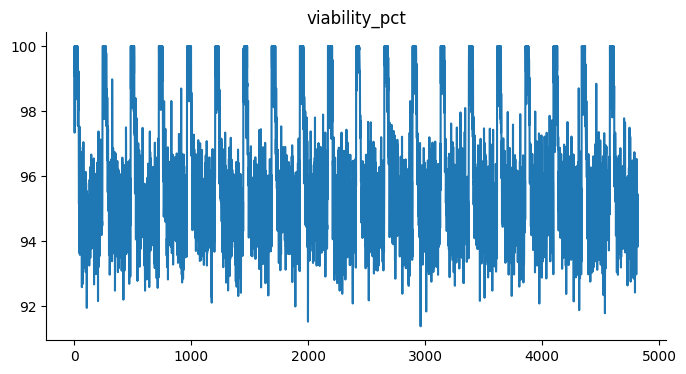

In [22]:
# @title viability_pct

from matplotlib import pyplot as plt
train_df['viability_pct'].plot(kind='line', figsize=(8, 4), title='viability_pct')
plt.gca().spines[['top', 'right']].set_visible(False)

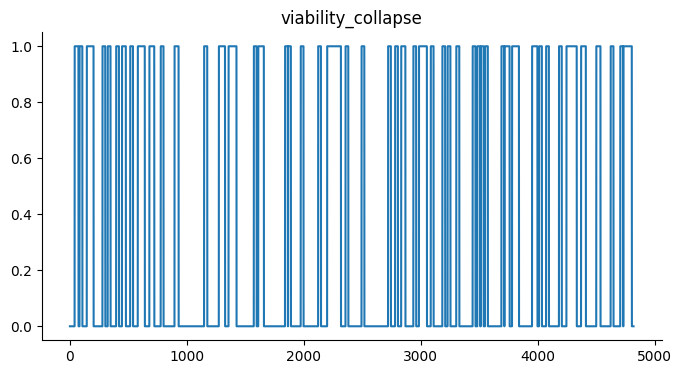

In [23]:
# @title viability_collapse

from matplotlib import pyplot as plt
train_df['viability_collapse'].plot(kind='line', figsize=(8, 4), title='viability_collapse')
plt.gca().spines[['top', 'right']].set_visible(False)

## 5. Upstream Viability Agent

In [24]:
class UpstreamViabilityAgent:
    def __init__(self, model_path="viability_collapse_rf.pkl"):
        self.model_path = model_path
        self.model = None

    def train(self, train_df):
        feat_cols = [
            'culture_time_hr', 'pH', 'temperature_C', 'viability_pct',
            'viable_cell_density_million_per_mL', 'dissolved_oxygen_pct',
            'carbon_dioxide_pct', 'titer_g_per_L', 'growth_rate_per_hr',
            'glucose_g_per_L', 'lactate_g_per_L', 'ammonia_mM', 'calcium_mM',
            'sodium_potassium_ratio', 'agitation_rpm', 'cell_bleed_volume_mL'
        ]
        X = train_df[feat_cols]
        y = train_df['viability_collapse']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        self.model = RandomForestClassifier()
        self.model.fit(X_train, y_train)
        print("Validation accuracy:", self.model.score(X_test, y_test))
        joblib.dump(self.model, self.model_path)

    def load(self):
        self.model = joblib.load(self.model_path)

    def predict(self, sample_row):
        # sample_row: sample dataframe, e.g. one hourly sample
        feat_cols = [
            'culture_time_hr', 'pH', 'temperature_C', 'viability_pct',
            'viable_cell_density_million_per_mL', 'dissolved_oxygen_pct',
            'carbon_dioxide_pct', 'titer_g_per_L', 'growth_rate_per_hr',
            'glucose_g_per_L', 'lactate_g_per_L', 'ammonia_mM', 'calcium_mM',
            'sodium_potassium_ratio', 'agitation_rpm', 'cell_bleed_volume_mL'
        ]
        features = sample_row[feat_cols] #.values.reshape(1, -1)
        pred = self.model.predict(features)
        return int(pred[0])  # 1=collapse, 0=no collapse


## 6. Real-time Prediction Pipeline

### step-1: Starting up the agent, creating predictive model on training data and saving the model

In [25]:
# Train and save the model
agent = UpstreamViabilityAgent()
agent.train(train_df)  # Only needs to be run once for initial training

Validation accuracy: 0.6773858921161826


### step-2: Loading the saved model and initiating the real-time bioprocess simulator

In [26]:
# For each new hourly sample from the simulator:
agent.load()  # Loads the saved model
sim = RealTimeBioprocessSimulator()

### step-3: pulling next datapoint from real-time simulator and the viability agent outputting the prediction

In [27]:
sample_row = sim.simulate_one_step() #.iloc[0]
print(sample_row)
collapse_pred = agent.predict(sample_row)
print(f"Viability collapse predicted: {collapse_pred}")

   culture_time_hr        pH  temperature_C  viability_pct  \
0                0  6.978875      37.045961          100.0   

   viable_cell_density_million_per_mL  dissolved_oxygen_pct  \
0                                 0.0             81.228736   

   carbon_dioxide_pct  titer_g_per_L  growth_rate_per_hr  glucose_g_per_L  \
0            0.041171       0.061852            0.572517         5.076342   

   lactate_g_per_L  ammonia_mM  calcium_mM  sodium_potassium_ratio  \
0              0.0         0.0     1.87534                2.105521   

   agitation_rpm  cell_bleed_volume_mL  
0     206.242642                     0  
Viability collapse predicted: 0


## LangGraph Multi-Agent Workflow

In [28]:
from google.colab import userdata
import os

# Access the API key from Colab secrets
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

### Step-1: Define LangGraph State and Nodes
LangGraph nodes are Python functions that take and return a State dict. Each holds agent instances and evolving data.

In [29]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
import pandas as pd # Ensure pandas is imported

class State(TypedDict):
    sim: RealTimeBioprocessSimulator
    agent: UpstreamViabilityAgent
    sample: pd.DataFrame
    prediction: int
    history: list # Added history to the State definition

# Simulator node
def simulator_node(state: State) -> State:
    sim = state.get('sim')
    if sim is None:
        sim = RealTimeBioprocessSimulator()
        state['sim'] = sim
    sample = sim.simulate_one_step()
    state['sample'] = sample
    # Append the sample data (converted to dict) to the history list in state
    # Initialize history if it doesn't exist (though run_workflow should handle this)
    if 'history' not in state or not isinstance(state['history'], list):
         state['history'] = []

    # Add the sample and prediction to the history for plotting/logging
    # We need the prediction to be available in the history for the log_str
    # Let's add the sample data and potentially the prediction (if available from a previous step)
    # A better approach might be to add prediction in the predictor_node and then update history
    # Let's simplify for now and just add the sample dict. We'll handle prediction logging differently.
    sample_dict = sample.iloc[0].to_dict()
    state['history'].append(sample_dict) # Append the sample data to history

    return state

# Predictor node
def predictor_node(state: State) -> State:
    agent = state.get('agent')
    if agent is None: # Initialize agent if not in state
        agent = UpstreamViabilityAgent()
        # Check if the model file exists before loading
        try:
            agent.load() # Load the saved model
            state['agent'] = agent
        except FileNotFoundError:
            print("Model file not found. Please train the agent first.")
            # Handle the error - perhaps set prediction to None or a specific error value
            state['prediction'] = -1 # Indicate error
            return state # Exit early if model not found

    sample = state.get('sample')
    if sample is None:
        print("No sample available for prediction.")
        state['prediction'] = -1 # Indicate no sample
        return state

    try:
        pred = agent.predict(sample)
        state['prediction'] = pred
         # Update the last entry in history with the prediction
        if state.get('history'):
            state['history'][-1]['viability_collapse_pred'] = pred
    except Exception as e:
        print(f"Error during prediction: {e}")
        state['prediction'] = -1 # Indicate error
        if state.get('history'):
             state['history'][-1]['viability_collapse_pred'] = -1 # Indicate error in history entry

    return state

### Step-2: Build and compile the LangGraph

In [30]:
graph = StateGraph(State)

graph.add_node('simulator', simulator_node)
graph.add_node('predictor', predictor_node)

graph.add_edge(START, 'simulator')
graph.add_edge('simulator', 'predictor')
graph.add_edge('predictor', END)

chain = graph.compile()


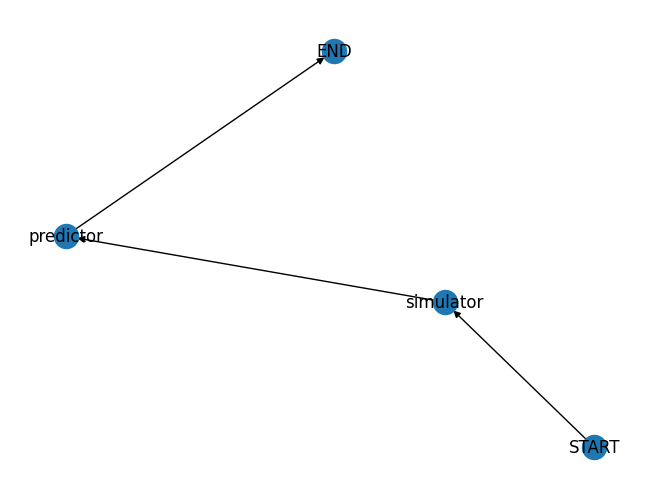

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

# manually build the structure
G = nx.DiGraph()
G.add_edges_from([
    ('START', 'simulator'),
    ('simulator', 'predictor'),
    ('predictor', 'END'),
])
nx.draw(G, with_labels=True, arrows=True)
plt.show()


### Step-3: Running the Multi-Agent Graph
Trigger the graph in a loop to simulate “real-time” streaming of samples

In [32]:
state = {}
num_hours = 100
results = []
for i in range(num_hours):
    state = chain.invoke(state)
    sample = state['sample']
    prediction = state['prediction']
    results.append({
        'hour': i,
        'viability_pct': sample['viability_pct'].iloc[0],
        'viability_collapse_pred': prediction
    })

import pprint
pprint.pprint(results)

[{'hour': 0,
  'viability_collapse_pred': 0,
  'viability_pct': np.float64(99.63092576499336)},
 {'hour': 1, 'viability_collapse_pred': 0, 'viability_pct': np.float64(100.0)},
 {'hour': 2,
  'viability_collapse_pred': 0,
  'viability_pct': np.float64(99.0818419663562)},
 {'hour': 3, 'viability_collapse_pred': 0, 'viability_pct': np.float64(100.0)},
 {'hour': 4,
  'viability_collapse_pred': 0,
  'viability_pct': np.float64(99.74203015557902)},
 {'hour': 5,
  'viability_collapse_pred': 0,
  'viability_pct': np.float64(99.70286611519411)},
 {'hour': 6, 'viability_collapse_pred': 0, 'viability_pct': np.float64(100.0)},
 {'hour': 7,
  'viability_collapse_pred': 0,
  'viability_pct': np.float64(99.9106601292012)},
 {'hour': 8, 'viability_collapse_pred': 0, 'viability_pct': np.float64(100.0)},
 {'hour': 9,
  'viability_collapse_pred': 0,
  'viability_pct': np.float64(99.84888044624937)},
 {'hour': 10,
  'viability_collapse_pred': 0,
  'viability_pct': np.float64(99.05349843232304)},
 {'hour':

### Step-4: Build a Gradio Interface with Live Updates

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def create_status_image(collapse_pred):
    # Create a simple 100x100 PNG with color based on prediction
    img = Image.new('RGB', (100, 100), color='white')
    draw = ImageDraw.Draw(img)
    if collapse_pred == 1:
        # Red circle = collapse
        draw.ellipse((10, 10, 90, 90), fill='red')
    else:
        # Green circle = no collapse
        draw.ellipse((10, 10, 90, 90), fill='green')
    return img

def run_workflow(n_steps, state=None):
    if state is None or not state:
        # Reinitialize state for new session, including history
        state = {'sim': None, 'agent': None, 'sample': None, 'prediction': None, 'history': []}
    # If upgrading legacy state, ensure 'history' key exists (for robustness)
    if 'history' not in state:
        state['history'] = []

    metrics = [] # This list seems intended for single step metrics, but is not used later. Let's keep it for now but note its potential redundancy.
    for _ in range(n_steps):
        state = chain.invoke(state)
        # The simulator_node is now responsible for updating state['history']
        # We still collect sample and prediction for the current step display
        sample = state.get('sample')
        prediction = state.get('prediction')
        if sample is not None:
             # The simulator_node already added the full sample to history
             # We don't need to append the dictionary here again if history is updated in simulator_node
             pass # Let simulator_node manage history

    print(f"Current state keys: {list(state.keys())}")
    # Use the history from the state which is updated by simulator_node
    df = pd.DataFrame(state.get('history', []))

    fig, ax = plt.subplots()
    if not df.empty and 'viability_pct' in df.columns: # Check for column existence
        df['viability_pct'].plot(ax=ax, label="Viability %")
        ax.set_xlabel("Hour")
        ax.set_ylabel("Viability (%)")
        ax.legend()
    plt.close(fig)
    # Create a simple log string from the latest sample in history
    log_str = "No data yet."
    status_img = Image.new('RGB', (100, 100), color='white')  # default blank image
    if not df.empty:
        latest_row = df.iloc[-1]
        latest_viability = latest_row.get('viability_pct', 'N/A')
        latest_prediction = latest_row.get('viability_collapse_pred', 'N/A') # Assuming prediction is added to history
        # We can't reliably get the actual collapse status here unless it's in the data
        # Let's log the predicted collapse status instead if available
        log_str = f"Step {len(df) - 1}: Viability = {latest_viability:.2f} | Collapse pred = {latest_prediction}"
        status_img = create_status_image(latest_prediction)

    # Pass the updated state back to Gradio
    return fig, df.tail(10), log_str, status_img, state # Add status_image to return values

with gr.Blocks() as demo:
    gr.Markdown("# Bioprocess Digital Twin — Live Multi-Agent Workflow Demo")
    with gr.Row():
        steps_slider = gr.Slider(1, 24, value=1, step=1, label="Advance simulation by N hours")
        run_btn = gr.Button("Run")
    with gr.Row():
        plot_box = gr.Plot(label="Viability (%) Over Time")
        table_box = gr.Dataframe(label="Latest Samples")
    with gr.Row():
        log_box = gr.Textbox(label="Agent Log", lines=2)
        status_image = gr.Image(label="Latest Prediction Outcome", type="pil", interactive=False) # Removed shape argument
    state_var = gr.State({}) # Gradio State component to maintain state

    run_btn.click(
        fn=run_workflow,
        inputs=[steps_slider, state_var],
        outputs=[plot_box, table_box, log_box, status_image, state_var] # Add status_image to outputs
    )

if __name__ == "__main__":
    demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0b04957a05beb1ac9d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Current state keys: ['sim', 'agent', 'sample', 'prediction', 'history']
Current state keys: ['sim', 'agent', 'sample', 'prediction', 'history']
Current state keys: ['sim', 'agent', 'sample', 'prediction', 'history']
Current state keys: ['sim', 'agent', 'sample', 'prediction', 'history']
Current state keys: ['sim', 'agent', 'sample', 'prediction', 'history']
Current state keys: ['sim', 'agent', 'sample', 'prediction', 'history']
Current state keys: ['sim', 'agent', 'sample', 'prediction', 'history']
Current state keys: ['sim', 'agent', 'sample', 'prediction', 'history']
